## Image Embedding Generation
This notebook shows how to extract embeddings from Torchvision ImageNet-pretrained models given the 
released manifest file and data. All ResNets, ViT-L-16, and ViT-H-14 have been tested to this point.
Other torchvision models may work, but could be implemented by specifying properly the name of the
last layer prior to the fully connected layer for a given model type. For all ResNets, the name of 
that layer is "flatten" whereas for ViT models, that layer is "getitem_5".

In [ ]:
"""
Install all the packages that are needed in this notebook.
"""
import sys
!{sys.executable} -m pip install matplotlib==3.10.3
!{sys.executable} -m pip install numpy==1.26.4
!{sys.executable} -m pip install pandas==2.2.3
!{sys.executable} -m pip install tifffile
!{sys.executable} -m pip install torch==2.2.2
!{sys.executable} -m pip install torchvision==0.17.2
!{sys.executable} -m pip install lightning==2.5.1
!{sys.executable} -m pip install tables==3.10.2

## Image Dataset object
Basic dataset object to load images from manifest, convert into float32 data type (if needed), 
and return single batches.

In [1]:
import numpy as np
import os
import pandas as pd
import tifffile
import torch
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(
        self,
        manifest_file: str,
        input_root_dir: str,
        input_stains_columns: tuple[str, ...] | None = None,
    ):
        """
        manifest_file: path to manifest
        input_root_dir: base path to which entries in manifest file are 
        concatenated to get full image paths
        input_stains_columns: names of columns in manifest that contain paths
        to input images
        """
        
        self.manifest = pd.read_hdf(manifest_path)
        self.input_root_dir = input_root_dir
        self.input_stains_columns = input_stains_columns
        
    def __getitem__(self, idx):
        # Load images from the columns that were picked out
        np_image_stack = np.stack(
            [
                tifffile.imread(
                    os.path.join(
                        self.input_root_dir,
                        self.manifest[colname].iloc[idx]
                    )
                ) 
                for colname in self.input_stains_columns
            ]
        )

        # Convert images from uint8 into float, if needed
        if np_image_stack.dtype == "uint8":
            np_image_stack = np_image_stack.astype(np.float32)/255

        return torch.from_numpy(np_image_stack)

    def __len__(self):
        return len(self.manifest)


## Model Class
Adapts torchvision pretrained models and turns them into feature extractors based on the 
last_node parameter specified, from which features will be extracted. Further classes that
adapt the feature extractor into single-channel and single-channel-agnostic feature extractors
are also provided, which loops through each channel of an input batch, does a forward pass,
and concatenates and returns the resulting features.

In [2]:
"""
Torchvision ViT that adapts torchvision pretrained models and turns them into
channel agnostic feature extractors.
"""

from collections import OrderedDict
from typing import Optional

import lightning as L
import torch
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor

class torchvision_vit(L.LightningModule):
    def __init__(
        self,
        model_name: str,
        pre_trained: bool = True,
        weights: str = "DEFAULT",
        in_channels: int = 3,
        out_classes: int = 1000,
        learning_rate: float = 1e-3,
        last_node: str = "getitem_5",
        **model_config,
    ):
        super().__init__()
        self.model_name = model_name
        self.pre_trained = pre_trained
        self.in_channels = in_channels
        self.out_classes = out_classes
        self.learning_rate = learning_rate
        self.last_node = last_node

        """
        Default weights for vit_h_14 is IMAGENET1K_SWAG_E2E_V1, which requires 
        images of size 518x518 for input. Select the pretrained checkpoint 
        available that is based off 224x224 inputs instead, which also is not 
        the default pretrained weight.
        """
        if self.model_name == "vit_h_14":
            weights = "IMAGENET1K_SWAG_LINEAR_V1"

        if "resnet" in self.model_name:
            self.last_node = "flatten"

        self.model = torchvision.models.get_model(
            self.model_name, weights=weights if self.pre_trained else None
        )
        self.model_weights = torchvision.models.get_model_weights(self.model_name)
        # assign model weights?

        modules = OrderedDict([*(list(self.model.named_children()))])
        if self.in_channels != 3:
            fl_name = list(modules.keys())[0]
            if isinstance(modules[fl_name], torch.nn.Conv2d):
                new_layer = torch.nn.Conv2d(
                    self.in_channels,
                    modules[fl_name].out_channels,
                    modules[fl_name].kernel_size,
                    stride=modules[fl_name].stride,
                    padding=modules[fl_name].padding,
                    dilation=modules[fl_name].dilation,
                    groups=modules[fl_name].groups,
                    bias=modules[fl_name].bias is not None,
                    padding_mode=modules[fl_name].padding_mode,
                )
                setattr(self.model, fl_name, new_layer)

        if self.out_classes != 10:
            ll_name = list(modules.keys())[-1]
            if "resnet" not in self.model_name:
                if isinstance(modules[ll_name][0], torch.nn.Linear):
                    new_layer = torch.nn.Sequential(
                        torch.nn.Linear(
                            modules[ll_name][0].in_features,
                            self.out_classes,
                            bias=modules[ll_name][0].bias is not None,
                        )
                    )
                    setattr(self.model, ll_name, new_layer)
            else:
                new_layer = torch.nn.Sequential(
                    torch.nn.Linear(
                        modules[ll_name].in_features,
                        self.out_classes,
                        bias=modules[ll_name].bias is not None,
                    )
                )
                setattr(self.model, ll_name, new_layer)

        self.final_activation = torch.nn.Softmax(dim=1)

        self.feature_extractor_fn = create_feature_extractor(
            self.model, return_nodes=[self.last_node]
        )
        
        self.prediction_keys = [
            "z",
            "logits",
            "predicted_activated",
            "predicted_ClassID",
        ]

    def set_prediction_cfg(self, prediction_keys: Optional[list[str]] = None):
        """
        Sets the prediction keys for the model when in inference mode (predict_step).
        This is used when calling trainer.predict, or in model.get_predictions and
        model.get_embeddings
        """
        if prediction_keys is not None:
            self.prediction_keys = prediction_keys

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

    def feature_extractor(self, img: torch.Tensor) -> torch.Tensor:
        return self.feature_extractor_fn(img)

    def forward(self, img: torch.Tensor) -> dict[str, torch.Tensor]:
        logits = self.model.forward(img)
        activated = self.final_activation(logits)
        classid = activated.argmax(dim=1, keepdims=True)
        predictions = {}
        predictions["logits"] = logits
        predictions["predicted_activated"] = activated
        predictions["predicted_ClassID"] = classid
        return predictions

    def predict_step(
        self,
        img: torch.Tensor,
        prediction_keys: Optional[list[str]] = None,
    ) -> dict[str, torch.Tensor]:
        if batch is None:  
            return None  
           

        
        self.set_prediction_cfg(prediction_keys)
        prediction_keys = self.prediction_keys

        # Get embeddings/predictions
        prediction = {}
        if any(
            [
                k in ["logits", "predicted_activated", "predicted_ClassID"]
                for k in prediction_keys
            ]
        ):
            prediction.update(
                self.forward(img)
            )  
        if "z" in prediction_keys:
            prediction["z"] = self.feature_extractor(batch["x_image"])[self.last_node]

        
        # Filter prediction based on requested keys
        for k in list(prediction):
            if k not in prediction_keys:
                del prediction[k]
                continue
            if isinstance(prediction[k], torch.Tensor):
                prediction[k] = prediction[k].detach().cpu().numpy()
            elif k in list(losses.keys()):  # these are metrics
                pass

        return prediction


class torchvision_vit_singlechannel(torchvision_vit):
    def forward(self, img: torch.Tensor) -> dict[str, torch.Tensor]:
        assert (
            img.shape[1] == 1
        ), f"Input image must have single channel, got {img.shape[1]} channels."
        img = img.repeat(1, 3, 1, 1)
        return super().forward(img)

    def feature_extractor(self, img: torch.Tensor) -> torch.Tensor:
        assert (
            img.shape[1] == 1
        ), f"Input image must have single channel, got {img.shape[1]} channels."
        img = img.repeat(1, 3, 1, 1)
        return super().feature_extractor(img)


class torchvision_vit_channelagnostic(torchvision_vit_singlechannel):
    def forward(self, img: torch.Tensor) -> dict[str, torch.Tensor]:
        num_channels = img.shape[1]
        preds = []
        for channel_idx in range(num_channels):
            prediction = super().forward(img[:, [channel_idx]])
            preds.append(prediction)

        # collate
        prediction = {}
        for k in preds[0]:
            if "image" in k:
                prediction[k] = torch.concat([p[k] for p in preds], dim=1)
            else:
                prediction[k] = torch.concat([p[k] for p in preds], dim=-1)
            # print(k, prediction[k].shape)

        return prediction

    def feature_extractor(self, img: torch.Tensor) -> torch.Tensor:
        num_channels = img.shape[1]
        preds = []
        for channel_idx in range(num_channels):
            prediction = super().feature_extractor(img[:, [channel_idx]])
            preds.append(prediction)

        # collate
        prediction = {}
        for k in preds[0]:
            if "image" in k:
                prediction[k] = torch.concat([p[k] for p in preds], dim=1)
            else:
                prediction[k] = torch.concat([p[k] for p in preds], dim=-1)
        return prediction

## Usage Example
Example of initializing dataset object and model, visualizing images, and doing
a forward pass to generate embeddings.

In [3]:
"""
Bulk variables. Change these to match locations on your local file system:
manifest_path: path to manifest
model_type: key in model_config_dict that will pick the correct torchvision model specific variables
image_root_path: base path to which entries in manifest file are concatenated to get full image paths
input_stains_columns: names of columns in manifest that contain paths to input images
model_name: torchvision model name from which you're extracting embeddings
(https://docs.pytorch.org/vision/main/models.html)
last_node: layer in model from which features are being extracted.
"""

model_type = "VITH-14" #pick one option from model_config_dict (VITL-16, VITH-14, RESNET50, RESNET152)
manifest_path = "../data/measured/imaging/round_1.h5"
image_root_path = "../data/"
input_stains_columns = ["path-DNA", "path-RNA", "path-AGP", "path-Mito", "path-ER"]

In [4]:
model_config_dict = {"VITL-16": ["vit_l_16","getitem_5"],
                     "VITH-14": ["vit_h_14","getitem_5"],
                     "RESNET50": ["resnet50","flatten"],
                     "RESNET152": ["resnet152","flatten"],}

model_name = model_config_dict[model_type][0]
last_node = model_config_dict[model_type][1]

L.seed_everything(12345)

Seed set to 12345


12345

In [5]:
"""
Image Dataset object.
"""
iter_dataset = ImageDataset(
    manifest_file = manifest_path,
    input_root_dir = image_root_path,
    input_stains_columns = input_stains_columns
)

In [6]:
"""
All torchvision ResNets, ViT-L-16, ViT-H-14 have been tested. 
Other torchvision models could be configured using similar framework,
but have not been tested.
"""
model = torchvision_vit_channelagnostic(
    model_name = model_name,
    pre_trained = True,
    weights = "DEFAULT",
    in_channels = 3,
    out_classes = 1000, #irrelevant output
    learning_rate = 1e-3,
    last_node = last_node,
)

In [7]:
"""
Load an example image, and extract the features 
"""
import random

img = iter_dataset.__getitem__(random.randint(0,len(iter_dataset)-1))
embeddings = model.feature_extractor(img.unsqueeze(0))
embeddings = embeddings[list(embeddings.keys())[0]].detach().cpu()
embeddings = [
    embeddings[:,(i * embeddings.shape[-1]//len(input_stains_columns)):
    ((i+1) * embeddings.shape[-1]//len(input_stains_columns))] 
    for i in range(len(input_stains_columns))
]
embedding_dict = {input_stains_columns[i].split("path-")[-1]: embeddings[i] for i in range(len(input_stains_columns))}

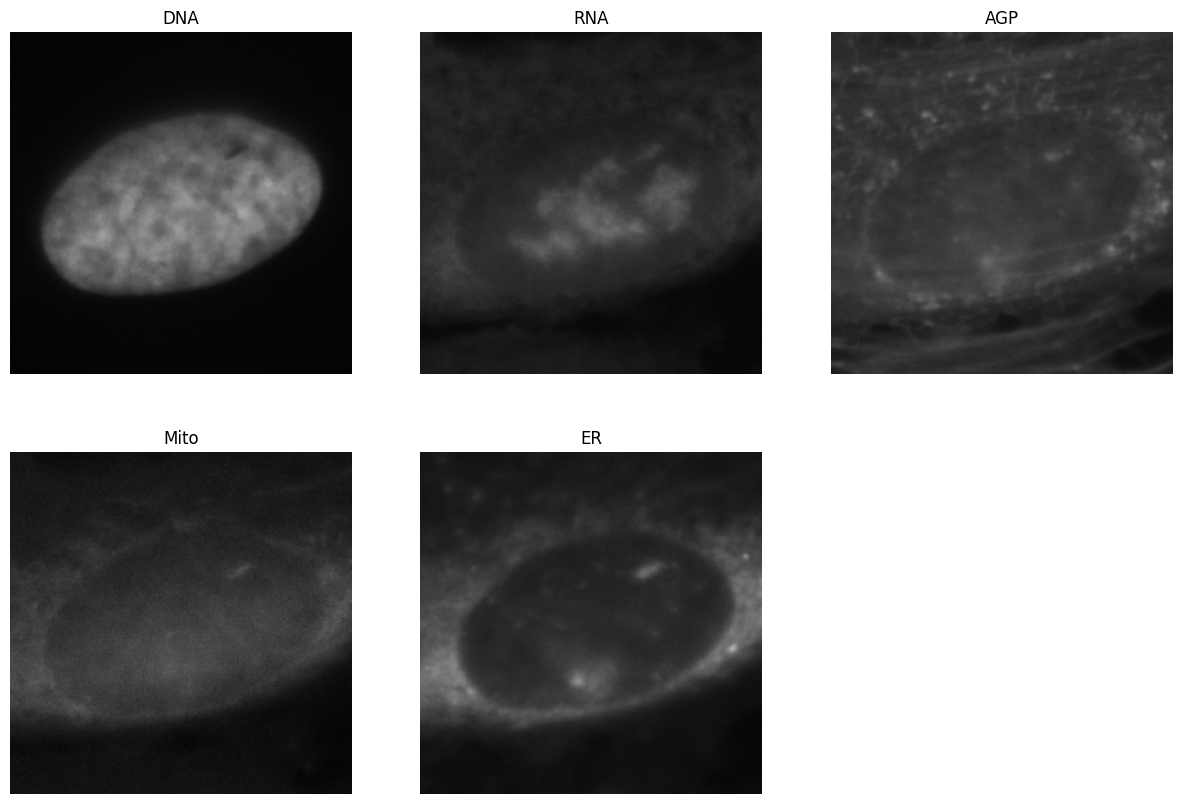

In [8]:
"""
Visualize the image that was pulled from the dataset
"""
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,10))
for subplot_num in range(len(input_stains_columns)):
    plt.subplot(2,3,subplot_num+1)
    plt.imshow(img[subplot_num,:],
               cmap = "gray",
               vmin = 0,
               vmax = 1)
    plt.axis("off")
    plt.title(input_stains_columns[subplot_num].split("path-")[-1])

In [9]:
"""
Show the generated embeddings, sorted by channel
"""
embedding_dict

{'DNA': tensor([[ 0.0101,  0.7326, -0.6863,  ..., -0.8663, -0.2426, -0.6296]]),
 'RNA': tensor([[ 0.3267,  0.1046,  0.0698,  ..., -0.0670, -0.8311, -0.3164]]),
 'AGP': tensor([[-0.6741,  0.5131, -0.4567,  ..., -0.2013, -0.4524, -0.3434]]),
 'Mito': tensor([[ 0.6649,  0.5503,  0.3010,  ..., -0.5804, -0.6338, -1.0097]]),
 'ER': tensor([[ 0.0366,  0.5348, -0.7243,  ..., -0.2528, -0.9265, -0.8934]])}